## Imports

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from easydict import EasyDict as edict

import tools.plot_tools as plot_tools
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Create sample track and measurmente classes

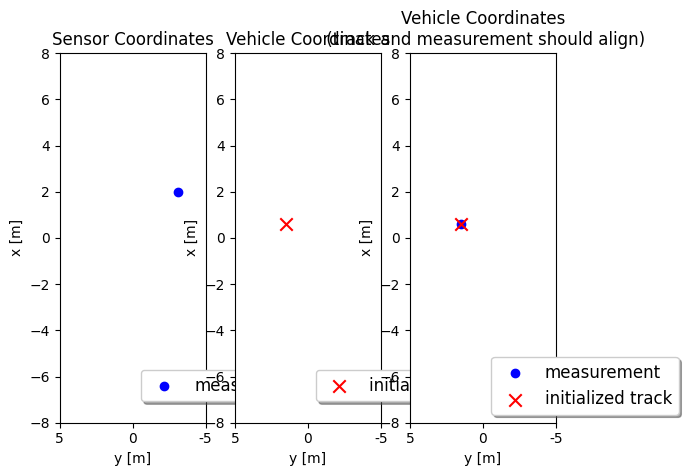

In [2]:


class Track:
    '''Track class with state, covariance, id'''
    def __init__(self, meas, id):
        self.id = id # Track id
        self.x = np.zeros((6,1)) # ID
        self.P = np.zeros((6, 6)) # Covariance
        
        # transform measurement to vehicle coordinates
        pos_sens = np.ones((4, 1)) # homogeneous coordinates
        pos_sens[0:3] = meas.z[0:3] # Counting that we are initiating with lidar measurement
        pos_veh = meas.T@pos_sens # Vehicle coordinates
        
        # save initial state from measurement
        self.x[0:3] = pos_veh[0:3]
        
        # Initialize error covariance of the position taking into account sensor rotation.
        M_rot = meas.T[0:3, 0:3]
        P_pos = M_rot * meas.R * np.transpose(M_rot)
        
        # Initialize error covariance of the velocity
        sigma_vxvx = 50 # initial setting for estimation error covariance P entry for vx
        sigma_vyvy = 50 # initial setting for estimation error covariance P entry for vy
        sigma_vzvz = 5 # initial setting for estimation error covariance P entry for vz
        P_vel = np.matrix([[sigma_vxvx**2, 0, 0],
                        [0, sigma_vyvy**2, 0],
                        [0, 0, sigma_vzvz**2]])
        
        self.P[0:3, 0:3] = P_pos
        self.P[3:6, 3:6] = P_vel
        
        
###################  
class Measurement:
    '''Lidar measurement class including measurement z, covariance R, coordinate transform matrix'''
    def __init__(self, sensor, detection):

        # coordiante transformation matrix from sensor to vehicle coordinates
        self.T = sensor.T       
        # transform ground truth from vehicle to sensor coordinates
        pos = detection.pos

        # create measurement object
        sigma_lidar_x = 0.01 # standard deviation for noisy measurement generation
        sigma_lidar_y = 0.01
        sigma_lidar_z = 0.001
        self.z = np.zeros((3,1)) # measurement vector
        self.z[0] = float(pos[0]) + np.random.normal(0, sigma_lidar_x)
        self.z[1] = float(pos[1]) + np.random.normal(0, sigma_lidar_y)
        self.z[2] = float(pos[2]) + np.random.normal(0, sigma_lidar_z)
        self.R = np.matrix([[sigma_lidar_x**2, 0, 0], # measurement noise covariance matrix
                            [0, sigma_lidar_y**2, 0], 
                            [0, 0, sigma_lidar_z**2]])
        

        
###################  
lidar = edict()
#sensor Transformation matrix
lidar.T = np.asarray([[0, -1, 0, -2.5],
           [1, 0, 0, -0.5],
           [0, 0, 1, 1],
           [0, 0, 0, 1]], dtype=float)

# detections
detection = edict()
detection.pos = [2.0, -3.1, -0.4]

# generate measurement
meas = Measurement(lidar, detection)

# initialize track from this measurement
track = Track(meas, 1)

# visualization
plot_tools.plot_track_init(track, meas)

## Implement FOV for a Camera Sensor

[[ 0.   1.   0.   0.5]
 [-1.  -0.  -0.  -2.5]
 [ 0.   0.   1.  -1. ]
 [ 0.   0.   0.   1. ]]


/tmp/ipykernel_10844/2456099580.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', 2)


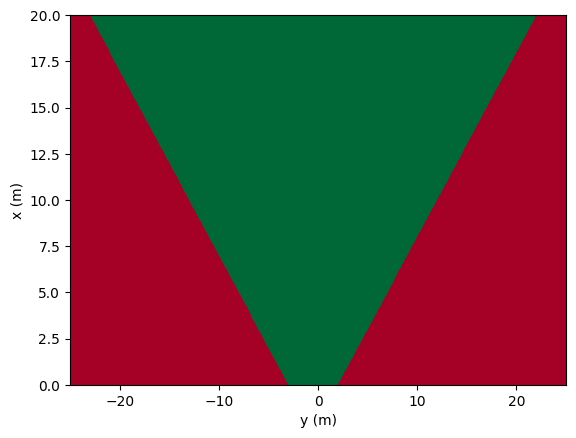

In [3]:

class Camera:
    '''Camera sensor class including field of view and coordinate transformation'''
    def __init__(self, camera_gt):
        self.fov = [-np.pi/4, np.pi/4] # sensor field of view / opening angle

        # coordiante transformation matrix from sensor to vehicle coordinates
        self.sens_to_veh = camera_gt.T           
        self.veh_to_sens = np.linalg.inv(self.sens_to_veh) # transformation vehicle to sensor coordinates
    
    def in_fov(self, x):
        # check if an object x can be seen by this sensor
        pos_veh = np.ones((4, x.shape[1])) # homogeneous coordinates
        pos_veh[0:3,:] = x[0:3,:] 
        pos_sens = self.veh_to_sens@pos_veh # transform from vehicle to sensor coordinates
        print(self.veh_to_sens)
        alpha = np.arctan(pos_sens[1]/pos_sens[0]) # calc angle between object and x-axis
        # no normalization needed because returned alpha always lies between [-pi/2, pi/2]
        return (alpha > self.fov[0]) & (alpha < self.fov[1])
        

cam = edict()
cam.T = np.asarray([[0, -1, 0, -2.5],
           [1, 0, 0, -0.5],
           [0, 0, 1, 1],
           [0, 0, 0, 1]], dtype=float)

camera = Camera(cam)


fig, ax = plt.subplots()
ax.set_xlabel("y (m)")
ax.set_ylabel("x (m)")

ax.set_xlim(-25,25)
ax.set_ylim(0,20)

xs = np.linspace(0, 20, 1000)
ys = np.linspace(-25,25,1000)

X,Y, = np.meshgrid(xs,ys)
Z = np.ones_like(X)
grid = np.zeros_like(X)

points = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis=-1).T
grid = camera.in_fov(points).reshape(X.shape)



cmap = plt.cm.get_cmap('RdYlGn', 2)

ax.pcolormesh(Y,X, ~grid, cmap=cmap)

plt.show()




In [4]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats.distributions import chi2

class Association:
    '''Data association class with single nearest neighbor association and gating based on Mahalanobis distance'''
    def __init__(self):
        self.association_matrix = np.matrix([])
        
    def associate(self, track_list, meas_list):
        N = len(track_list) # N tracks
        M = len(meas_list) # M measurements
        
        # initialize association matrix
        self.association_matrix = np.inf*np.ones((N,M)) 
        
        # loop over all tracks and all measurements to set up association matrix
        for i in range(N): 
            track = track_list[i]
            for j in range(M):
                meas = meas_list[j]
                dist = self.Mahalanobis(track, meas)
                # gating
                if dist < chi2.ppf(0.95, df=2):
                    self.association_matrix[i,j] = dist
        
    def Mahalanobis(self, track, meas):
        # calc Mahalanobis distance
        H = np.matrix([[1, 0, 0, 0],
                       [0, 1, 0, 0]]) 
        gamma = meas.z - H*track.x
        S = H*track.P*H.transpose() + meas.R
        MHD = gamma.transpose()*np.linalg.inv(S)*gamma # Mahalanobis distance formula
        return MHD
         